# SNS Sentiment Analysis LR

Analyze social media texts and measure potential inflammatory / offensive language with a logistic regression.

In [1]:
import ast
import pandas as pd
import data_util as du
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

# Load data

In [2]:
# Load dataset
train = pd.read_csv("./datasets/processed/train.csv")
X_train = train[train.columns[0]].apply(ast.literal_eval)
y_train = train[train.columns[1]].astype(int)
print(X_train.shape, y_train.shape)

test = pd.read_csv("./datasets/processed/test.csv")
X_test = test[test.columns[0]].apply(ast.literal_eval)
y_test = test[test.columns[1]].astype(int)
print(X_test.shape, y_test.shape)

# Load vocabulary
vocabulary = ast.literal_eval(open("./datasets/processed/vocabulary.txt", "r").read())
print("Vocabulary size:", len(vocabulary))

(8000,) (8000,)
(2000,) (2000,)
Vocabulary size: 11560


In [3]:
train_text = [" ".join(s) for s in X_train]
test_text = [" ".join(s) for s in X_test]
print("Lengths of train and test:", len(train_text), len(test_text))

Lengths of train and test: 8000 2000


# Vectorize data

In multinomial vectorization, we use it to calculate probabilities based on frequency of words from the vocabulary than whether the word has appeared at least once.

In [4]:
m_vectorizer = CountVectorizer(input='content', stop_words='english', binary=False, vocabulary=vocabulary, tokenizer=None, preprocessor=None)
X_train_m = m_vectorizer.fit_transform(train_text)
X_test_m = m_vectorizer.transform(test_text)

b_vectorizer = CountVectorizer(input='content', stop_words='english', binary=True, vocabulary=vocabulary, tokenizer=None, preprocessor=None)
X_train_b = b_vectorizer.fit_transform(train_text)
X_test_b = b_vectorizer.transform(test_text)

print("Vocabulary sizes:", len(m_vectorizer.get_feature_names_out()), len(b_vectorizer.get_feature_names_out()))

Vocabulary sizes: 11560 11560


# Build logistic regression model and train

In [23]:
# Multinomial with L1 penalty
lr_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000, multi_class='ovr')

In [24]:
lr_model.fit(X_train_m, y_train)

LogisticRegression(C=0.1, max_iter=1000, multi_class='ovr', penalty='l1',
                   solver='liblinear')

In [25]:
# Multinomial with L2 penalty, manually tuned
lr_model_2 = LogisticRegression(C=1, penalty='l2', multi_class='ovr')

In [26]:
lr_model_2.fit(X_train_m, y_train)

LogisticRegression(C=1, multi_class='ovr')

In [34]:
# Binomial, no tuning
lr_model_3 = LogisticRegression(warm_start=True)
lr_model_3.fit(X_train_b, y_train)

LogisticRegression(warm_start=True)

## Tuned Logistic Regression

In [14]:
# Hyperparameter tuning
pipe = Pipeline([
    ('vectorizer', CountVectorizer(input='content', stop_words='english', binary=False, vocabulary=vocabulary, tokenizer=None, preprocessor=None)),
    ('classifier', LogisticRegression(solver='liblinear'))
])

param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', verbose=1)

In [27]:
grid_search.fit(train_text, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english',
                                                        vocabulary=['starzzzvictori',
                                                                    'dese',
                                                                    'fronz',
                                                                    'suck',
                                                                    'donna',
                                                                    'murphi',
                                                                    'flash',
                                                                    'htmlyoutub',
                                                                    'lone',
                                                                    'blame',
                                                                    'massachusett',
                                                                    'worm',
                                                                    'poopil',
                                                                    'boost',
                                                                    'contempl',
                                                                    'shay',
                                                                    'lib',
                                                                    'letter',
                                                                    'digit',
                                                                    'meatloaf',
                                                                    'vicin',
                                                                    'exposur',
                                                                    'grovel',
                                                                    'markov',
                                                                    'memoriesofidot',
                                                                    'handssaidclap',
                                                                    'gamestopcontest',
                                                                    'sexist',
                                                                    'cbs',
                                                                    'laugh', ...])),
                                       ('classifier',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2'],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

In [37]:
best_params = grid_search.best_params_
print(best_params)

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'vectorizer__ngram_range': (1, 1)}


In [52]:
best_model = LogisticRegression(C=best_params.get('classifier__C'), penalty=best_params.get('classifier__penalty'))

In [53]:
best_vectorizer = CountVectorizer(input='content', stop_words='english', binary=False, vocabulary=vocabulary, tokenizer=None, preprocessor=None, ngram_range=(best_params.get('vectorizer__ngram_range')))

X_train_best = best_vectorizer.fit_transform(train_text)
X_test_best = best_vectorizer.transform(test_text)

In [54]:
best_model.fit(X_train_best, y_train)

LogisticRegression(C=0.1)

In [9]:
# Save as pickle
with open("./models/sns_multinomial_lr.pkl", "wb") as f:
    pickle.dump(lr_model, f)

In [10]:
# Save as pickle
with open("./models/sns_multinomial_lr_2.pkl", "wb") as f:
    pickle.dump(lr_model_2, f)

In [28]:
# Save as pickle
with open("./models/sns_binomial_lr.pkl", "wb") as f:
    pickle.dump(lr_model_3, f)

In [55]:
# Save as pickle
with open("./models/sns_best_lr.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [29]:
# Load from pickle
lr_model = pickle.load(open("./models/sns_multinomial_lr.pkl", "rb"))
lr_model_2 = pickle.load(open("./models/sns_multinomial_lr_2.pkl", "rb"))
lr_model_3 = pickle.load(open("./models/sns_binomial_lr.pkl", "rb"))
best_model = pickle.load(open("./models/sns_best_lr.pkl", "rb"))

# Make predictions

In [14]:
# Multinomial with L1 penalty
lr_pred_probs = lr_model.predict_proba(X_test_m)
lr_preds = lr_model.predict(X_test_m)

In [15]:
_ = du.get_prfa(y_test, lr_preds, verbose=True)

Precision: 0.6677713338856669
Recall: 0.8116817724068479
F1 Score: 0.7327272727272727
Accuracy: 0.706


In [16]:
# Multinomial with L2 penalty
lr_model_2_preds = lr_model_2.predict(X_test_m)
_ = du.get_prfa(y_test, lr_model_2_preds, verbose=True)

Precision: 0.7146974063400576
Recall: 0.7492447129909365
F1 Score: 0.7315634218289084
Accuracy: 0.727


In [35]:
# Binomial predictions
lr_model_3_preds = lr_model_3.predict(X_test_b)
_ = du.get_prfa(y_test, lr_model_3_preds, verbose=True)

Precision: 0.7217973231357553
Recall: 0.7603222557905337
F1 Score: 0.7405590975968611
Accuracy: 0.7355


In [56]:
# Tuned model predictions
best_model_preds = best_model.predict(X_test_best)
_ = du.get_prfa(y_test, best_model_preds, verbose=True)

Precision: 0.7113309352517986
Recall: 0.796576032225579
F1 Score: 0.7515439429928742
Accuracy: 0.7385


In [17]:
def predict_inflammatory_level(text):
    vec_text = m_vectorizer.transform([text])
    return float(lr_model.predict_proba(vec_text)[:, 1])

In [18]:
example = predict_inflammatory_level("This is regular text")
example_pred = du.probs_to_preds([[example]])
print("Likeliness of inflammatory language:", example)
print("Prediction:", example_pred, "(not inflammatory)")

Likeliness of inflammatory language: 0.4011701403007382
Prediction: [0] (not inflammatory)


In [59]:
def remove_duplicate_labels(ax_graph):
    handles, labels = ax_graph.get_legend_handles_labels()
    unique = [(h, l) for j, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:j]]
    ax_graph.legend(*zip(*unique))

# Plot training history and performance

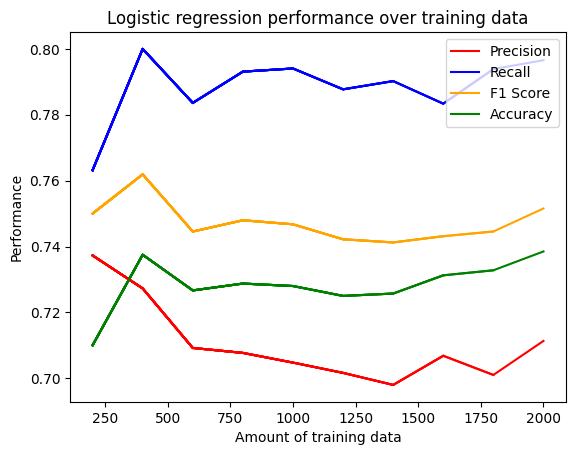

In [60]:
x_values = []
train_sizes = range(10, 101, 10)
metrics_dict = dict({
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': []
})

fig, ax = plt.subplots()
preds = best_model_preds

for i in train_sizes:
    # |X| * percent of train size
    subset = int(round(len(preds) * (float(i) / float(100))))
    x_values.append(subset)

    pred_subset = int(round(len(y_test) * (float(i) / float(100))))
    classification = preds[:pred_subset]
    (precision, recall, f1, accuracy) = du.get_prfa(y_test[:pred_subset], classification, verbose=False)

    metrics_dict['precision'].append(precision)
    metrics_dict['recall'].append(recall)
    metrics_dict['f1'].append(f1)
    metrics_dict['accuracy'].append(accuracy)

    ax.plot(x_values, metrics_dict['precision'], label='Precision', color='red')
    ax.plot(x_values, metrics_dict['recall'], label='Recall', color='blue')
    ax.plot(x_values, metrics_dict['f1'], label='F1 Score', color='orange')
    ax.plot(x_values, metrics_dict['accuracy'], label='Accuracy', color='green')

plt.xlabel("Amount of training data")
plt.ylabel("Performance")
plt.title("Logistic regression performance over training data")
remove_duplicate_labels(ax)
plt.savefig('./graphs/lr_history_best.png')
plt.show()

# Additional graphing of training & test scores

Accuracies & receiving operator characteristic area under curve

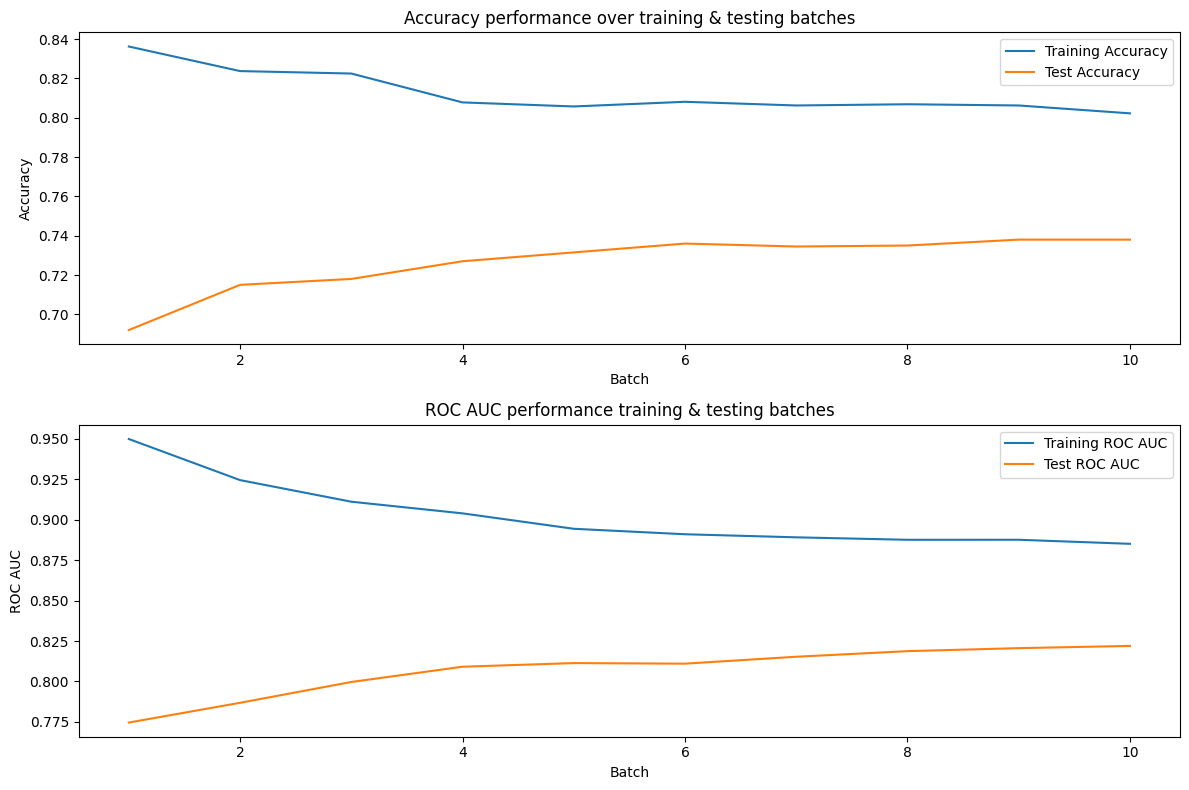

In [57]:
train_accuracies = []
test_accuracies = []
train_roc_aucs = []
test_roc_aucs = []

lr = best_model

# Train the model in batches and store performance
for i in range(10):
    lr.fit(X_train_b[:len(X_train_b.toarray()) // 10 * (i + 1)], y_train[:len(y_train) // 10 * (i + 1)])
    
    # Compute performance metrics
    train_acc = accuracy_score(y_train[:len(y_train) // 10 * (i + 1)], lr.predict(X_train_b[:len(X_train_b.toarray()) // 10 * (i + 1)]))
    test_acc = accuracy_score(y_test, lr.predict(X_test_b.toarray()))
    train_roc_auc = roc_auc_score(y_train[:len(y_train) // 10 * (i + 1)], lr.predict_proba(X_train_b.toarray()[:len(X_train_b.toarray()) // 10 * (i + 1)])[:, 1])
    test_roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test_b.toarray())[:, 1])
    
    # Store performance metrics
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_roc_aucs.append(train_roc_auc)
    test_roc_aucs.append(test_roc_auc)

# Plot performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(range(1, 11), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Accuracy performance over training & testing batches')
plt.legend()
plt.savefig('./graphs/lr_best_accuracy.png')

plt.subplot(2, 1, 2)
plt.plot(range(1, 11), train_roc_aucs, label='Training ROC AUC')
plt.plot(range(1, 11), test_roc_aucs, label='Test ROC AUC')
plt.xlabel('Batch')
plt.ylabel('ROC AUC')
plt.title('ROC AUC performance training & testing batches')
plt.legend()
plt.tight_layout()
plt.savefig('./graphs/lr_best_roc_auc.png')
plt.show()